In [2]:
# N-BEATS (Neural Basis Expansion Analysis Time Series Forecasting)

In [4]:
# pip install numpy pandas matplotlib yfinance torch

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler

In [7]:
# Load Bitcoin data
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2024-01-01', interval='1d')
btc_close = btc_data['Close'].dropna()



[*********************100%%**********************]  1 of 1 completed


In [8]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(btc_close.values.reshape(-1, 1))

In [12]:
# Create sequences for training
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

In [14]:
# Prepare the dataset
SEQ_LENGTH = 30  # Use the last 30 days to predict the next day
sequences = create_sequences(scaled_data, SEQ_LENGTH)
X = sequences[:, :-1]  # All but the last element in each sequence
y = sequences[:, -1]    # The last element in each sequence (the next day price)

In [16]:
# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.FloatTensor(y)

In [18]:
# Split into training and testing datasets
train_size = int(len(X_tensor) * 0.8)
X_train, X_test = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_test = y_tensor[:train_size], y_tensor[train_size:]

In [40]:
X_train = X_train.view(X_train.size(0), -1)  # Reshape to (1144, 29)


In [42]:
# Define the N-BEATS model
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(NBeatsBlock, self).__init__()
        self.backcast = nn.Linear(input_size, input_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        backcast = self.backcast(x)
        forecast = self.fc2(torch.relu(self.fc1(backcast)))
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, num_blocks, input_size, output_size, hidden_size):
        super(NBeats, self).__init__()
        self.blocks = nn.ModuleList([NBeatsBlock(input_size, output_size, hidden_size) for _ in range(num_blocks)])
    
    def forward(self, x):
        forecasts = []
        for block in self.blocks:
            backcast, forecast = block(x)
            forecasts.append(forecast)
            x = backcast  # use the backcast as input to the next block
        return forecasts


In [44]:
# Instantiate the model
num_blocks = 3
input_size = SEQ_LENGTH - 1
output_size = 1
hidden_size = 128

nbeats_model = NBeats(num_blocks, input_size, output_size, hidden_size)

In [46]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(nbeats_model.parameters(), lr=0.001)

In [52]:
# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    nbeats_model.train()
    optimizer.zero_grad()
    
    # Forward pass
    output = nbeats_model(X_train)

    # Only take the forecast from the last block
    forecast = output[-1]  # Shape: (batch_size, 1)

    # Compute the loss
    loss = criterion(forecast.squeeze(), y_train.squeeze())  # Use squeeze() on y_train to match shapes
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0288
Epoch [20/100], Loss: 0.0060
Epoch [30/100], Loss: 0.0049
Epoch [40/100], Loss: 0.0037
Epoch [50/100], Loss: 0.0030
Epoch [60/100], Loss: 0.0026
Epoch [70/100], Loss: 0.0023
Epoch [80/100], Loss: 0.0020
Epoch [90/100], Loss: 0.0018
Epoch [100/100], Loss: 0.0016


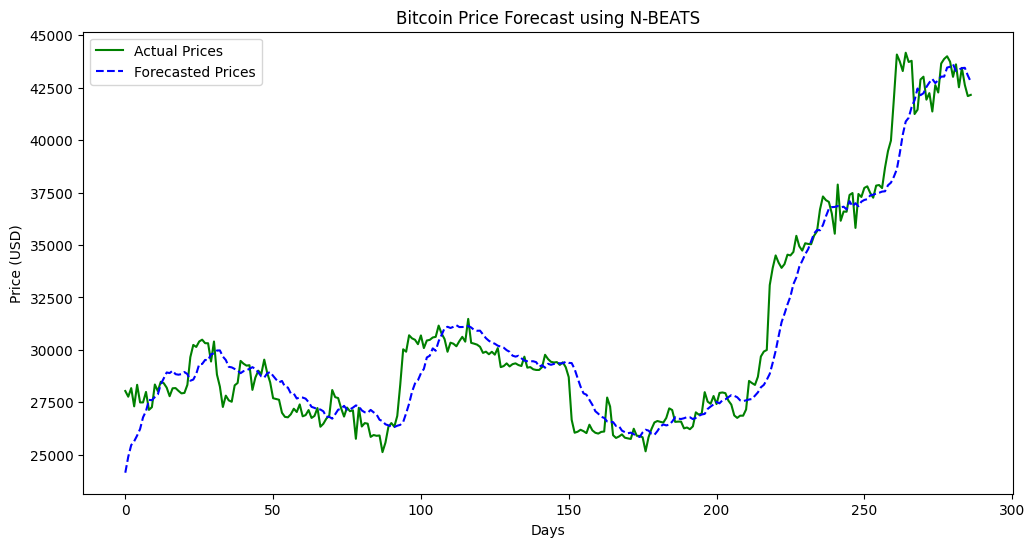

In [58]:
# Make predictions
nbeats_model.eval()
with torch.no_grad():
    # Reshape X_test
    X_test_flat = X_test.view(X_test.size(0), -1)  # Reshape to (num_samples, 29)
    forecasted_values = nbeats_model(X_test_flat)[-1].squeeze().numpy()

# Inverse transform to get actual prices
forecasted_prices = scaler.inverse_transform(forecasted_values.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual_prices)), actual_prices, label='Actual Prices', color='green')
plt.plot(range(len(forecasted_prices)), forecasted_prices, label='Forecasted Prices', color='blue', linestyle='--')
plt.title('Bitcoin Price Forecast using N-BEATS')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()
